In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.pyplot import rc_context
from tqdm import tqdm
from scipy.optimize import curve_fit
import random


import scvi
import pickle
from adjustText import adjust_text

import itertools
from numba import jit

import senepy as sp

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## load/harmonize adata

In [2]:

adata = sc.read_h5ad('../data/tms/tms-scVI-raw-data_BDATA.h5ad')


In [3]:
coords = sc.read_h5ad('../data/tms/TMS_BDATA_UMAP_COORDS.h5ad').obsm['X_umap']
adata.obsm['X_umap'] = coords

In [4]:
hubs = sp.load_hubs(species = 'Mouse')

In [5]:
adata

AnnData object with n_obs × n_vars = 328498 × 20116
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'tissue2', 'tissue_cell', 'cell_type_2'
    var: 'n_cells-0', 'n_cells-1'
    obsm: 'X_scvi', 'X_umap'

In [6]:
temp = adata.obs.groupby([ 'tissue2', 'cell_type_2']).count()
temp=temp[temp.age > 0]['age']


/tmp/ipykernel_2267680/3742651915.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = adata.obs.groupby([ 'tissue2', 'cell_type_2']).count()


In [7]:
to_test = temp.reset_index().sort_values('age', ascending = False)
to_test

,tissue2,cell_type_2,age
86,Lymphoid,B cell,41537
100,Myeloid,monocyte,21785
88,Lymphoid,T cell,21779
98,Myeloid,granulocyte,15269
61,Limb_Muscle,mesenchymal stem cell,13972
...,...,...,...
115,Skin,macrophage,13
77,Lung,lung neuroendocrine cell,8
83,Lung,type I pneumocyte,4
42,Kidney,kidney cell,3


In [8]:
#going to pick one hub per cell/tissue. If cell/tissue hub not present, pick cell-type with highest hyp
#if no cell type, pick highest other hyp
def pick_hub(tissue, cell):
    temp = hubs.metadata[(hubs.metadata.tissue == tissue) & (hubs.metadata.cell == cell)].sort_values('hyp')
    if len(temp) > 0:
        return (temp.iloc[0].tissue, temp.iloc[0].cell, temp.iloc[0].hub_num)
    
    temp = hubs.metadata[(hubs.metadata.cell == cell)].sort_values('hyp')
    if len(temp) > 0:
        return (temp.iloc[0].tissue, temp.iloc[0].cell, temp.iloc[0].hub_num)
    
    temp = hubs.metadata.sort_values('hyp')
    return (temp.iloc[0].tissue, temp.iloc[0].cell, temp.iloc[0].hub_num) 
        

In [9]:
scores = {}
what_hubs = {}

for row in tqdm(range(len(to_test))):
    sub = adata[(adata.obs.tissue2 == to_test.loc[row].tissue2) &\
                (adata.obs.cell_type_2 == to_test.loc[row].cell_type_2)]
    
    sel_hub = pick_hub(to_test.loc[row].tissue2, to_test.loc[row].cell_type_2)
    
    res = sp.score_hub(sub, hubs.hubs[sel_hub])
    
    scores = scores | dict(zip(sub.obs.index, res))
    what_hubs[(to_test.loc[row].tissue2, to_test.loc[row].cell_type_2)] = sel_hub
    

100%|█████████████████████████████████████████| 138/138 [03:26<00:00,  1.50s/it]


In [10]:
for item in what_hubs:
    print(item, what_hubs[item])

('Bladder', 'bladder cell') ('Bladder', 'bladder cell', 2)
('Bladder', 'bladder urothelial cell') ('Tongue', 'keratinocyte', 0)
('Bladder', 'endothelial cell') ('Bladder', 'endothelial cell', 1)
('Brain', 'astrocyte') ('Tongue', 'keratinocyte', 0)
('Brain', 'endothelial cell') ('Fat', 'endothelial cell', 0)
('Brain', 'ependymal cell') ('Tongue', 'keratinocyte', 0)
('Brain', 'macrophage') ('Kidney', 'macrophage', 0)
('Brain', 'microglial cell') ('Tongue', 'keratinocyte', 0)
('Brain', 'neuroepithelial cell') ('Tongue', 'keratinocyte', 0)
('Brain', 'neuron') ('Tongue', 'keratinocyte', 0)
('Brain', 'neuronal stem cell') ('Tongue', 'keratinocyte', 0)
('Brain', 'oligodendrocyte') ('Tongue', 'keratinocyte', 0)
('Brain', 'oligodendrocyte precursor cell') ('Tongue', 'keratinocyte', 0)
('Brain', 'pericyte') ('Tongue', 'keratinocyte', 0)
('Diaphragm', 'endothelial cell') ('Fat', 'endothelial cell', 0)
('Diaphragm', 'macrophage') ('Kidney', 'macrophage', 0)
('Diaphragm', 'mesenchymal stem cell') (

In [11]:
adata.obs['sen_score'] = adata.obs.index.map(scores)

In [12]:
adata

AnnData object with n_obs × n_vars = 328498 × 20116
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'tissue2', 'tissue_cell', 'cell_type_2', 'sen_score'
    var: 'n_cells-0', 'n_cells-1'
    obsm: 'X_scvi', 'X_umap'

In [13]:
#means/stds for each tissue-cell

means = {}
stds = {}
for row in tqdm(range(len(to_test))):
    sub = adata[(adata.obs.tissue2 == to_test.loc[row].tissue2) &\
                (adata.obs.cell_type_2 == to_test.loc[row].cell_type_2)]
    means[(to_test.loc[row].tissue2, to_test.loc[row].cell_type_2)] = sub.obs.sen_score.mean()
    stds[(to_test.loc[row].tissue2, to_test.loc[row].cell_type_2)] = sub.obs.sen_score.std()
    

100%|████████████████████████████████████████| 138/138 [00:00<00:00, 164.01it/s]


In [14]:
#means/stds for each tissue-cell-age

means_a = {}
stds_a = {}
for row in tqdm(range(len(to_test))):
    for age in ['3m', '24m']:
        sub = adata[(adata.obs.tissue2 == to_test.loc[row].tissue2) &\
                    (adata.obs.cell_type_2 == to_test.loc[row].cell_type_2) &\
                   (adata.obs.age == age)]

        if len(sub) > 0:

            means_a[(to_test.loc[row].tissue2, to_test.loc[row].cell_type_2, age)] = sub.obs.sen_score.mean()
            stds_a[(to_test.loc[row].tissue2, to_test.loc[row].cell_type_2, age)] = sub.obs.sen_score.std()
    

100%|████████████████████████████████████████| 138/138 [00:01<00:00, 100.54it/s]


In [15]:
def find_outliers(x):
    age, tissue, cell, score = x

    try:
        mean = means[(tissue, cell)]
        std = stds[(tissue, cell)]
        #mean_a = means_a[(tissue, cell, age)]
        #stds_a = stds_a[(tissue, cell, age)]
    except:
        return False

    if score > mean + std*3:
        return True
    else:
        return False
    
def find_outliers_v2(x):
    age, tissue, cell, score = x

    try:
        mean = means[(tissue, cell)]
        std = stds[(tissue, cell)]
        mean_a = means_a[(tissue, cell, age)]
        std_a = stds_a[(tissue, cell, age)]
    except:
        return False

    if (score > mean + std*3) & (score > mean_a + std_a):
        return True
    else:
        return False
    
    
    

In [16]:
adata.obs['sen_outlier'] = adata.obs[['age', 'tissue2', 'cell_type_2', 'sen_score']]\
        .apply(find_outliers, axis = 1)
adata.obs['sen_outlier_v2'] = adata.obs[['age', 'tissue2', 'cell_type_2', 'sen_score']]\
        .apply(find_outliers_v2, axis = 1)

In [17]:
bdata = adata[adata.obs.age.isin(['3m', '24m'])]

In [18]:
bdata

View of AnnData object with n_obs × n_vars = 148355 × 20116
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'tissue2', 'tissue_cell', 'cell_type_2', 'sen_score', 'sen_outlier', 'sen_outlier_v2'
    var: 'n_cells-0', 'n_cells-1'
    obsm: 'X_scvi', 'X_umap'

In [19]:
len(bdata[(bdata.obs.sen_outlier) & (bdata.obs.age == '3m')])/len(bdata)*100

0.35590307033804053

In [20]:
len(bdata[(bdata.obs.sen_outlier) & (bdata.obs.age == '24m')])/len(bdata)*100

1.2288092750497117

In [21]:
len(bdata[(bdata.obs.sen_outlier_v2) & (bdata.obs.age == '3m')])/len(bdata)*100

0.3545549526473661

In [22]:
len(bdata[(bdata.obs.sen_outlier_v2) & (bdata.obs.age == '24m')])/len(bdata)*100

1.209261568534933

In [23]:
tissue_cells = bdata.obs.groupby(['tissue2', 'cell_type_2']).size().reset_index().rename(columns={0:'Count'})
tissue_cells = tissue_cells[tissue_cells.Count > 0].reset_index(drop = True)
tissue_cells

/tmp/ipykernel_2267680/1316894505.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tissue_cells = bdata.obs.groupby(['tissue2', 'cell_type_2']).size().reset_index().rename(columns={0:'Count'})


,tissue2,cell_type_2,Count
0,Bladder,bladder cell,2570
1,Bladder,bladder urothelial cell,4663
2,Bladder,endothelial cell,188
3,Brain,astrocyte,525
4,Brain,endothelial cell,874
...,...,...,...
131,Trachea,mesenchymal cell,879
132,Trachea,mesenchymal progenitor cell,1676
133,Trachea,mucus secreting cell,66
134,Trachea,neuroendocrine cell,48


In [24]:
bdata.obs

,age,batch,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_counts,n_genes,sex,subtissue,tissue,tissue_free_annotation,tissue2,tissue_cell,cell_type_2,sen_score,sen_outlier,sen_outlier_v2
index,,,,,,,,,,,,,,,,,,,,
AAACCTGCAGGGTACA-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGGGTACA,keratinocyte,NA,filiform,droplet,24-M-60,NaN,2107.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte,1.875908,False,False
AAACCTGCAGTAAGCG-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGTAAGCG,keratinocyte,NA,suprabasal,droplet,24-M-60,NaN,3481.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte,0.890806,False,False
AAACCTGTCATTATCC-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGTCATTATCC,keratinocyte,NA,suprabasal,droplet,24-M-60,NaN,2599.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte,-0.033727,False,False
AAACGGGGTACAGTGG-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTACAGTGG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,NaN,3468.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte,-0.059022,False,False
AAACGGGGTCTTCTCG-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTCTTCTCG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,NaN,3189.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte,2.674308,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P9.MAA001844.3_38_F.1.1-1-1-1-1,3m,1,nan,hematopoietic stem cell,CL:0002035,MPP Fraction B,facs,3_38_F,800879.0,2988.0,female,KLS,Marrow,nan,HSC,Marrow_hematopoietic stem cell,hematopoietic stem cell,-0.063467,False,False
P9.MAA001883.3_39_F.1.1-1-1-1-1,3m,1,nan,naive B cell,CL:0000788,naïve B cell,facs,3_39_F,198660.0,1867.0,female,B-cells,Marrow,nan,Lymphoid,Marrow_naive B cell,B cell,0.508530,False,False
P9.MAA001887.3_39_F.1.1-1-1-1-1,3m,1,nan,hematopoietic stem cell,CL:0002035,MPP Fraction B + C,facs,3_39_F,227378.0,2919.0,female,KLS,Marrow,nan,HSC,Marrow_hematopoietic stem cell,hematopoietic stem cell,-0.072755,False,False


In [26]:
#this makes sure the outlier is an outlier for all ages
bdata.obs['is_sen'] = bdata.obs.sen_outlier_v2

/tmp/ipykernel_2267680/903160068.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  bdata.obs['is_sen'] = bdata.obs.sen_outlier_v2


In [27]:
#separate of age
bdata.obs['is_sen'] = bdata.obs.sen_outlier

# Measure proportion of sen at different ages

In [28]:
adata = bdata.copy()# so i dont have to redo everything below

#bdata is only 3/24m

In [30]:
class_d = pd.read_csv('../data/annotations/cell_class_annotation.csv')
class_d['class'] = class_d['class'].replace('resident immune', 'immune')

class_d['cell_type_2'] = class_d.cell_ontology_class.map(dict(zip(adata.obs.cell_ontology_class, adata.obs.cell_type_2)))


class_d = dict(zip(class_d.cell_type_2, class_d['class']))

class_d['monocyte'] = 'immune' #not sure what happened here haha
class_d['basal cell of epidermis'] = 'parenchymal'
class_d['myloid progenitor'] = 'immune'
class_d['immature B cell'] = 'immune'

adata.obs['Class'] = adata.obs.cell_type_2.map(class_d)

In [31]:
adata.obs

,age,batch,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_counts,n_genes,...,tissue,tissue_free_annotation,tissue2,tissue_cell,cell_type_2,sen_score,sen_outlier,sen_outlier_v2,is_sen,Class
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGCAGGGTACA-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGGGTACA,keratinocyte,NA,filiform,droplet,24-M-60,NaN,2107.0,...,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte,1.875908,False,False,False,parenchymal
AAACCTGCAGTAAGCG-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGTAAGCG,keratinocyte,NA,suprabasal,droplet,24-M-60,NaN,3481.0,...,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte,0.890806,False,False,False,parenchymal
AAACCTGTCATTATCC-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGTCATTATCC,keratinocyte,NA,suprabasal,droplet,24-M-60,NaN,2599.0,...,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte,-0.033727,False,False,False,parenchymal
AAACGGGGTACAGTGG-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTACAGTGG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,NaN,3468.0,...,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte,-0.059022,False,False,False,parenchymal
AAACGGGGTCTTCTCG-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTCTTCTCG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,NaN,3189.0,...,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte,2.674308,False,False,False,parenchymal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P9.MAA001844.3_38_F.1.1-1-1-1-1,3m,1,nan,hematopoietic stem cell,CL:0002035,MPP Fraction B,facs,3_38_F,800879.0,2988.0,...,Marrow,nan,HSC,Marrow_hematopoietic stem cell,hematopoietic stem cell,-0.063467,False,False,False,progenitor
P9.MAA001883.3_39_F.1.1-1-1-1-1,3m,1,nan,naive B cell,CL:0000788,naïve B cell,facs,3_39_F,198660.0,1867.0,...,Marrow,nan,Lymphoid,Marrow_naive B cell,B cell,0.508530,False,False,False,progenitor
P9.MAA001887.3_39_F.1.1-1-1-1-1,3m,1,nan,hematopoietic stem cell,CL:0002035,MPP Fraction B + C,facs,3_39_F,227378.0,2919.0,...,Marrow,nan,HSC,Marrow_hematopoietic stem cell,hematopoietic stem cell,-0.072755,False,False,False,progenitor


In [32]:
def another_fun_y(x):
    age, thing = x
    if (age == '1m' or age == '3m') and thing == 1:
        return 'young pos'
    return 'neg'

def another_fun_o(x):
    age, thing = x
    if (age == '24m' or age == '30m') and thing == 1:
        return 'old pos'
    return 'neg'

In [33]:
adata.obs['thing_young'] = adata.obs[['age', 'is_sen']].apply(another_fun_y, axis = 1)
adata.obs['thing_old'] = adata.obs[['age', 'is_sen']].apply(another_fun_o, axis = 1)

### Fig 5A

In [40]:
sc.set_figure_params(dpi_save = 600)

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default va

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


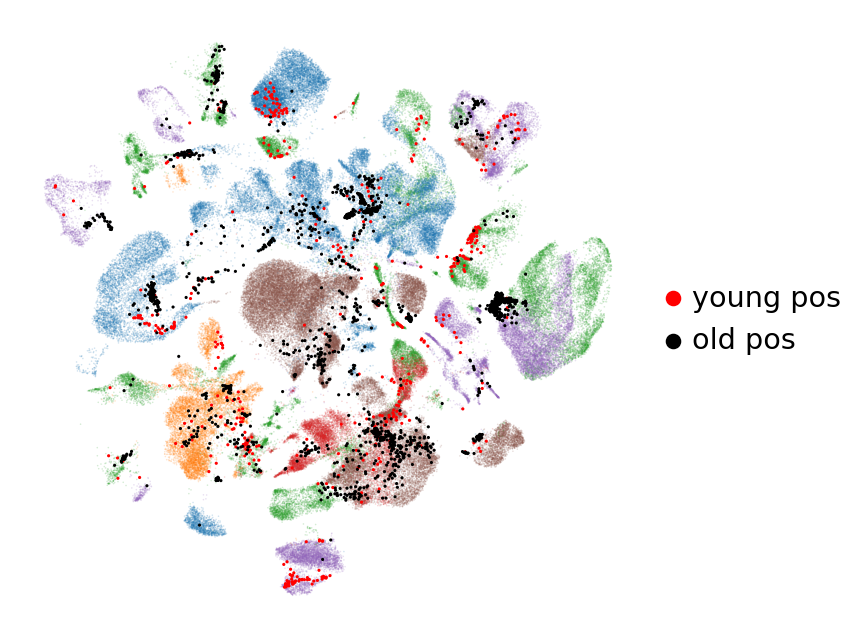

In [42]:
with rc_context({'figure.figsize': (5,5)}):
    ax = sc.pl.umap(adata, frameon = False, s = 2, color = 'Class', alpha = 0.2,
                    legend_loc = None, show = False,
                    palette = ['tab:orange', 'tab:purple', 'tab:blue', 'tab:green', 'tab:brown',  'tab:red'])

#palette = ['whitesmoke']
    
    sc.pl.umap(adata[adata.obs.thing_young != 'neg'], color = 'thing_young', s = 8, palette = ['red'],
               ax = ax, title = '', show = False)
    
    sc.pl.umap(adata[adata.obs.thing_old != 'neg'], color = 'thing_old', s = 8, palette = ['k'],
               ax = ax, title = '', save = '_5A_pt1.png')

In [37]:
adata.obs[['age', 'is_sen']].groupby('age').sum()

/tmp/ipykernel_2267680/2280944153.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs[['age', 'is_sen']].groupby('age').sum()


,is_sen
age,
3m,528
24m,1823


In [38]:
adata.obs

,age,batch,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_counts,n_genes,...,tissue2,tissue_cell,cell_type_2,sen_score,sen_outlier,sen_outlier_v2,is_sen,Class,thing_young,thing_old
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGCAGGGTACA-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGGGTACA,keratinocyte,NA,filiform,droplet,24-M-60,NaN,2107.0,...,Tongue,Tongue_keratinocyte,keratinocyte,1.875908,False,False,False,parenchymal,neg,neg
AAACCTGCAGTAAGCG-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGTAAGCG,keratinocyte,NA,suprabasal,droplet,24-M-60,NaN,3481.0,...,Tongue,Tongue_keratinocyte,keratinocyte,0.890806,False,False,False,parenchymal,neg,neg
AAACCTGTCATTATCC-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGTCATTATCC,keratinocyte,NA,suprabasal,droplet,24-M-60,NaN,2599.0,...,Tongue,Tongue_keratinocyte,keratinocyte,-0.033727,False,False,False,parenchymal,neg,neg
AAACGGGGTACAGTGG-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTACAGTGG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,NaN,3468.0,...,Tongue,Tongue_keratinocyte,keratinocyte,-0.059022,False,False,False,parenchymal,neg,neg
AAACGGGGTCTTCTCG-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTCTTCTCG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,NaN,3189.0,...,Tongue,Tongue_keratinocyte,keratinocyte,2.674308,False,False,False,parenchymal,neg,neg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P9.MAA001844.3_38_F.1.1-1-1-1-1,3m,1,nan,hematopoietic stem cell,CL:0002035,MPP Fraction B,facs,3_38_F,800879.0,2988.0,...,HSC,Marrow_hematopoietic stem cell,hematopoietic stem cell,-0.063467,False,False,False,progenitor,neg,neg
P9.MAA001883.3_39_F.1.1-1-1-1-1,3m,1,nan,naive B cell,CL:0000788,naïve B cell,facs,3_39_F,198660.0,1867.0,...,Lymphoid,Marrow_naive B cell,B cell,0.508530,False,False,False,progenitor,neg,neg
P9.MAA001887.3_39_F.1.1-1-1-1-1,3m,1,nan,hematopoietic stem cell,CL:0002035,MPP Fraction B + C,facs,3_39_F,227378.0,2919.0,...,HSC,Marrow_hematopoietic stem cell,hematopoietic stem cell,-0.072755,False,False,False,progenitor,neg,neg


/tmp/ipykernel_2267680/113476985.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x = ['young', 'old'], y = [temp_val1,temp_val2], palette = ['red', 'k'])


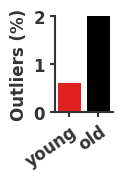

In [39]:
temp_val1 = len(adata.obs[adata.obs['thing_young'] == 'young pos'])\
    /len(adata.obs[adata.obs.age.isin(['1m', '3m'])])*100

temp_val2 = len(adata.obs[adata.obs['thing_old'] == 'old pos'])\
    /len(adata.obs[adata.obs.age.isin(['24m', '30m'])])*100

plt.figure(figsize = (0.75, 1.25))
ax = sns.barplot(x = ['young', 'old'], y = [temp_val1,temp_val2], palette = ['red', 'k'])


for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(1.5)
    ax.spines[axis].set_color('0.2')
ax.tick_params(width = 1.5, color = '0.2')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(size = 12, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold', color = '0.2')
plt.yticks(size = 12, weight = 'bold', color = '0.2')

plt.ylabel('Outliers (%)', size = 12, weight = 'bold', color = '0.2')

plt.ylim(top = 2)

ax.grid(False)

plt.savefig('figures/5A_pt2.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/5A_pt2.svg', bbox_inches = 'tight')


plt.show()

In [38]:
aaa = adata.obs[['tissue2', 'cell_type_2', 'is_sen']].groupby(['tissue2', 'cell_type_2']).sum().reset_index()

aaa = aaa[aaa.is_sen > 0].reset_index(drop = True)

aaa

/tmp/ipykernel_1850213/3994912694.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aaa = adata.obs[['tissue2', 'cell_type_2', 'is_sen']].groupby(['tissue2', 'cell_type_2']).sum().reset_index()


,tissue2,cell_type_2,is_sen
0,Bladder,bladder cell,102
1,Bladder,bladder urothelial cell,58
2,Bladder,endothelial cell,8
3,Brain,astrocyte,4
4,Brain,endothelial cell,7
...,...,...,...
98,Trachea,mesenchymal cell,9
99,Trachea,mesenchymal progenitor cell,9
100,Trachea,mucus secreting cell,3
101,Trachea,neuroendocrine cell,2


In [39]:
big_out = []

for y in tqdm(range(len(aaa))):
    sub = adata[(adata.obs.tissue2 == aaa.iloc[y].tissue2) & (adata.obs.cell_type_2 == aaa.iloc[y].cell_type_2)]
    
    out2 = []
    for age in ['1m', '3m', '18m', '21m', '24m', '30m']:
        age_sub = sub[sub.obs.age == age]
        
        if len(age_sub) < 100:
            out2.append(np.nan)
            continue
            
        out2.append(age_sub.obs.is_sen.sum()/len(age_sub))
    
    big_out.append([aaa.iloc[y].tissue2, aaa.iloc[y].cell_type_2] + out2)


100%|█████████████████████████████████████████| 103/103 [00:02<00:00, 38.77it/s]


In [40]:
sen = pd.DataFrame(big_out, columns = ['tissue', 'cell','1m', '3m', '18m', '21m', '24m', '30m'])

In [41]:
def get_increase(x):
    
    x = x.fillna(-1)
    
    if x['3m'] != -1:
        start = x['3m']
    elif x['1m'] != -1:
        start = x['1m']
    else:
        start = 0 #kidney podocyte has nan for 1m and 3m.. not sure how but to prevent error need this
        
        
    old = x[x.index.isin(['24m', '30m'])].max() #is max the right choice?
    
    return old - start
    

In [42]:
sen['gain'] = sen[['1m', '3m', '18m', '21m', '24m', '30m']].apply(get_increase, axis = 1)

sen['tissue_cell'] = sen.tissue + '_' + sen.cell

In [43]:
sen = sen[sen.gain > 0]

In [44]:
sen = sen.sort_values('gain', ascending = False).reset_index(drop = True)

In [45]:
sen['Class'] = sen.cell.map(class_d)

In [46]:
sen

,tissue,cell,1m,3m,18m,21m,24m,30m,gain,tissue_cell,Class
0,Kidney,epithelial cell of proximal tubule,NaN,0.000000,NaN,NaN,0.212670,NaN,0.212670,Kidney_epithelial cell of proximal tubule,epithelial
1,Trachea,fibroblast,NaN,0.000000,NaN,NaN,0.162500,NaN,0.162500,Trachea_fibroblast,stromal
2,Lung,fibroblast,NaN,0.003145,NaN,NaN,0.156757,NaN,0.153612,Lung_fibroblast,stromal
3,Bladder,bladder cell,NaN,0.003183,NaN,NaN,0.140146,NaN,0.136963,Bladder_bladder cell,parenchymal
4,Pancreas,pancreatic B cell,NaN,0.003831,NaN,NaN,0.134658,NaN,0.130826,Pancreas_pancreatic B cell,parenchymal
5,Trachea,macrophage,NaN,0.000000,NaN,NaN,0.122340,NaN,0.122340,Trachea_macrophage,immune
6,Thymus,thymocyte,NaN,0.000000,NaN,NaN,0.116224,NaN,0.116224,Thymus_thymocyte,parenchymal
7,Heart_and_Aorta,endocardial cell,NaN,0.000000,NaN,NaN,0.114815,NaN,0.114815,Heart_and_Aorta_endocardial cell,parenchymal
8,Pancreas,pancreatic acinar cell,NaN,0.036649,NaN,NaN,0.146552,NaN,0.109903,Pancreas_pancreatic acinar cell,parenchymal
9,Liver,hepatocyte,NaN,0.004317,NaN,NaN,0.111842,NaN,0.107526,Liver_hepatocyte,parenchymal


In [47]:
# #optional filter out cells that dont have a hub:
# def another_filter(x):
#     tissue, cell = x
#     #hub that was used to score cell
#     what_was_used = what_hubs[(tissue, cell)]
    
#     if what_was_used[0] == tissue and what_was_used[1] == cell:
#         return True
    
#     return False

# sen = sen[sen[['tissue', 'cell']].apply(another_filter, axis = 1)]

### Fig 5C

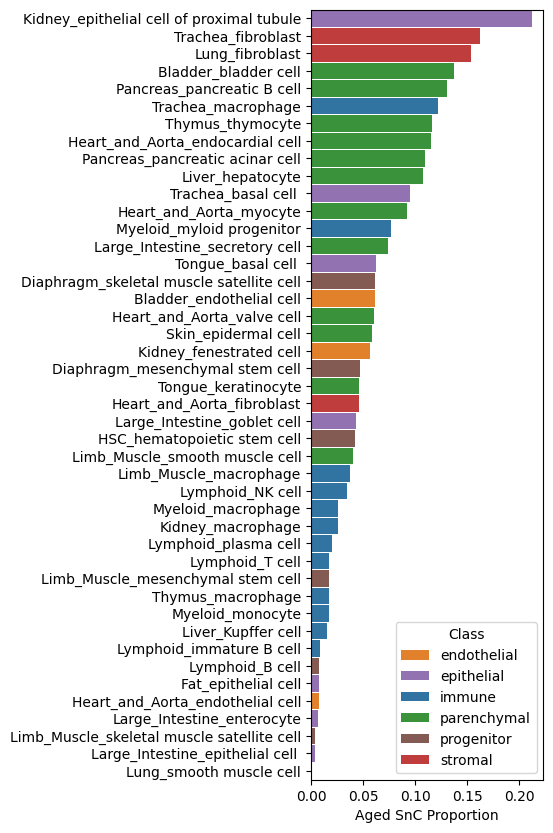

In [63]:
#v2 all
plt.figure(figsize = (3,10))

ax = sns.barplot(data = sen, x = 'gain', y = 'tissue_cell', hue = 'Class', dodge=False, width = 0.95,
                hue_order = ['endothelial', 'epithelial', 'immune', 'parenchymal', 'progenitor', 'stromal'], 
                palette = ['tab:orange', 'tab:purple', 'tab:blue', 'tab:green', 'tab:brown',  'tab:red'])

plt.ylabel('')
plt.xlabel('Aged SnC Proportion')

plt.savefig('figures/5C.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/5C.svg', bbox_inches = 'tight')

plt.show()

In [52]:
#lets see correlation to ki67 and tert
sen.head()

,tissue,cell,1m,3m,18m,21m,24m,30m,gain,tissue_cell,Class
0,Kidney,epithelial cell of proximal tubule,NaN,0.000000,NaN,NaN,0.212670,NaN,0.212670,Kidney_epithelial cell of proximal tubule,epithelial
1,Trachea,fibroblast,NaN,0.000000,NaN,NaN,0.162500,NaN,0.162500,Trachea_fibroblast,stromal
2,Lung,fibroblast,NaN,0.003145,NaN,NaN,0.156757,NaN,0.153612,Lung_fibroblast,stromal
3,Bladder,bladder cell,NaN,0.003183,NaN,NaN,0.140146,NaN,0.136963,Bladder_bladder cell,parenchymal
4,Pancreas,pancreatic B cell,NaN,0.003831,NaN,NaN,0.134658,NaN,0.130826,Pancreas_pancreatic B cell,parenchymal


In [53]:
ki67i = np.where(bdata.var_names == 'Mki67')[0][0]
ki = bdata[:,ki67i]


def get_ki67_pp(x):
    tissue, cell = x
    sub = ki[(ki.obs.tissue2 == tissue) & (ki.obs.cell_type_2 == cell)].X.toarray()
    a = sub[:,0]
    b = a[a >0]
    
    if len(a) == 0:
        print(tissue)
        return 0
    
    return len(b)/len(a)

In [54]:
sen['ki67_pp'] = sen[['tissue', 'cell']].apply(get_ki67_pp, axis = 1)

In [55]:
i = np.where(bdata.var_names == 'Tert')[0][0]
ki = bdata[:,i]


def get_tert_pp(x):
    tissue, cell = x
    sub = ki[(ki.obs.tissue2 == tissue) & (ki.obs.cell_type_2 == cell)].X.toarray()
    a = sub[:,0]
    b = a[a >0]
    
    if len(a) == 0:
        print(tissue)
        return 0
    
    return len(b)/len(a)

sen['tert_pp'] = sen[['tissue', 'cell']].apply(get_tert_pp, axis = 1)

### Sup Fig 5A

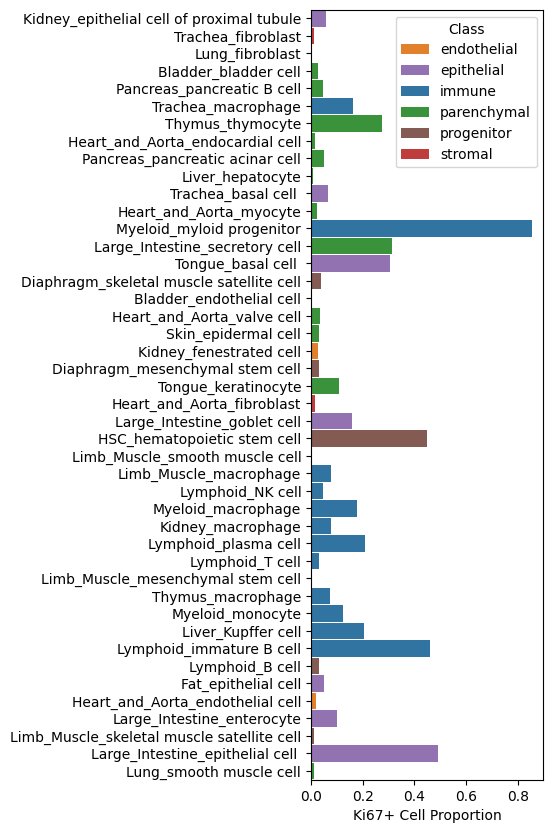

In [56]:
#pp of cells expressing ki67
plt.figure(figsize = (3,10))

ax = sns.barplot(data = sen, x = 'ki67_pp', y = 'tissue_cell', hue = 'Class', dodge=False, width = 0.95,
                hue_order = ['endothelial', 'epithelial', 'immune', 'parenchymal', 'progenitor', 'stromal'], 
                palette = ['tab:orange', 'tab:purple', 'tab:blue', 'tab:green', 'tab:brown',  'tab:red'])



plt.ylabel('')
plt.xlabel('Ki67+ Cell Proportion')

plt.savefig('figures/S5A.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/S5A.svg', bbox_inches = 'tight')

plt.show()

### Sup Fig 5C

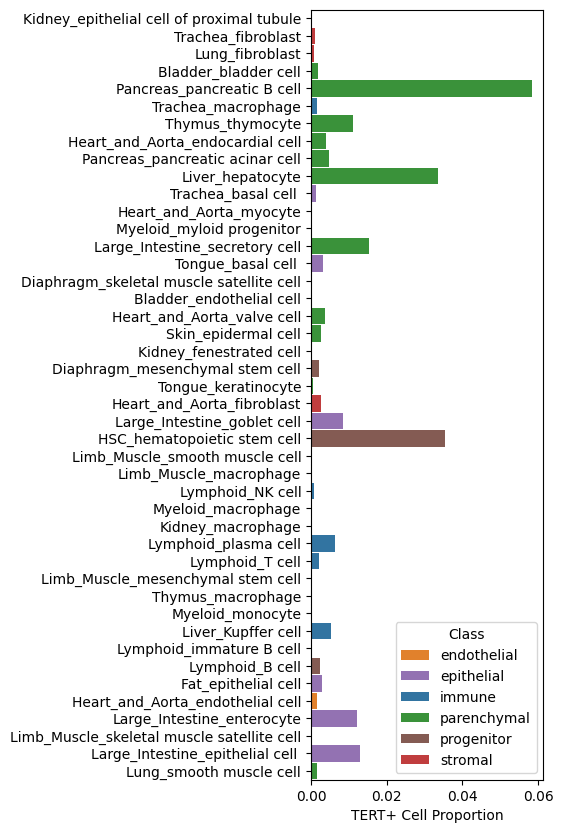

In [57]:
#pp of cells expressing tert
plt.figure(figsize = (3,10))

ax = sns.barplot(data = sen, x = 'tert_pp', y = 'tissue_cell', hue = 'Class', dodge=False, width = 0.95,
                hue_order = ['endothelial', 'epithelial', 'immune', 'parenchymal', 'progenitor', 'stromal'], 
                palette = ['tab:orange', 'tab:purple', 'tab:blue', 'tab:green', 'tab:brown',  'tab:red'])

plt.ylabel('')
plt.xlabel('TERT+ Cell Proportion')

plt.savefig('figures/S5C.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/S5C.svg', bbox_inches = 'tight')

plt.show()

In [58]:
sen[sen.tissue == 'Large_Intestine']

,tissue,cell,1m,3m,18m,21m,24m,30m,gain,tissue_cell,Class,ki67_pp,tert_pp
13,Large_Intestine,secretory cell,NaN,0.000000,NaN,NaN,0.074074,NaN,0.074074,Large_Intestine_secretory cell,parenchymal,0.314578,0.015345
23,Large_Intestine,goblet cell,NaN,0.000000,NaN,NaN,0.043651,NaN,0.043651,Large_Intestine_goblet cell,epithelial,0.160535,0.008361
40,Large_Intestine,enterocyte,NaN,0.015306,NaN,NaN,0.021739,NaN,0.006433,Large_Intestine_enterocyte,epithelial,0.100694,0.012153
42,Large_Intestine,epithelial cell,NaN,0.000000,NaN,NaN,0.003546,NaN,0.003546,Large_Intestine_epithelial cell,epithelial,0.489655,0.012931


In [162]:
i = np.where(bdata.var_names == 'Cdkn2a')[0][0]
ki = bdata[:,i]
ki = ki[ki.obs.age.isin(['21m','24m', '30m'])]

def get_tert_pp(x):
    tissue, cell = x
    sub = ki[(ki.obs.tissue2 == tissue) & (ki.obs.cell_type_2 == cell)].X.toarray()
    a = sub[:,0]
    b = a[a >0]
    
    if len(a) == 0:
        print(tissue)
        return 0
    
    return len(b)/len(a)

sen['cdkn2a_pp'] = sen[['tissue', 'cell']].apply(get_tert_pp, axis = 1)

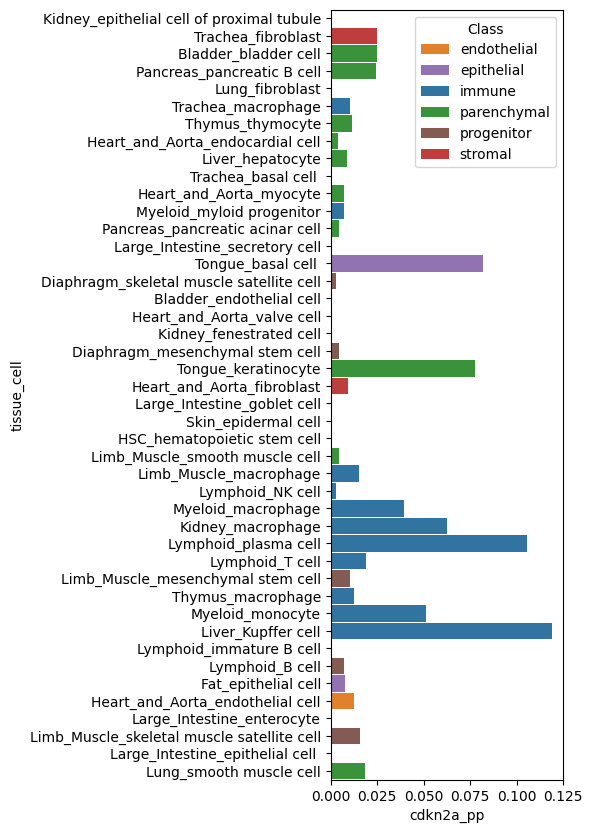

In [163]:
#pp of cells expressing cdkn2a
plt.figure(figsize = (3,10))

ax = sns.barplot(data = sen, x = 'cdkn2a_pp', y = 'tissue_cell', hue = 'Class', dodge=False, width = 0.95,
                hue_order = ['endothelial', 'epithelial', 'immune', 'parenchymal', 'progenitor', 'stromal'], 
                palette = ['tab:orange', 'tab:purple', 'tab:blue', 'tab:green', 'tab:brown',  'tab:red'])

In [170]:
stats.pearsonr(sen.gain, sen.ki67_pp)

PearsonRResult(statistic=-0.09837339708735962, pvalue=0.52523687550234)

In [171]:
stats.pearsonr(sen.gain, sen.tert_pp)

PearsonRResult(statistic=0.21374544869406534, pvalue=0.16356812395511247)

In [172]:
stats.pearsonr(sen.gain, sen.cdkn2a_pp)

PearsonRResult(statistic=-0.1863068160926894, pvalue=0.22594201602508096)

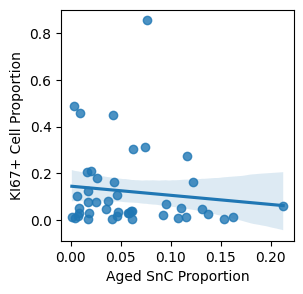

In [60]:
plt.figure(figsize = (3,3))

ax = sns.regplot(data = sen, x = 'gain', y = 'ki67_pp')

plt.xlabel('Aged SnC Proportion')
plt.ylabel('KI67+ Cell Proportion')

plt.savefig('figures/S5B.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/S5B.svg', bbox_inches = 'tight')

plt.show()

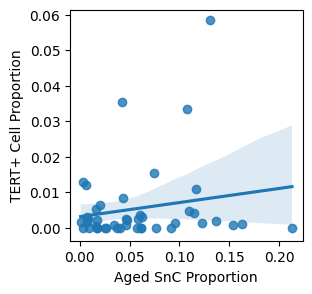

In [61]:
plt.figure(figsize = (3,3))

ax = sns.regplot(data = sen, x = 'gain', y = 'tert_pp')

plt.xlabel('Aged SnC Proportion')
plt.ylabel('TERT+ Cell Proportion')

plt.savefig('figures/S5D.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/S5D.svg', bbox_inches = 'tight')

plt.show()